In [1]:
%load_ext rpy2.ipython

import pandas as pd
from metasub_utils.packet_parse import MetaSUBTableFactory
from capalyzer.packet_parser.experimental import umap
import warnings

warnings.filterwarnings('ignore')

core_tabler = MetaSUBTableFactory.core_factory()

In [2]:
%%R

library(ggthemes)
library(ggplot2)
library(reshape2)
library(gridExtra)
library(ALDEx2)
library(RColorBrewer)

## Beta Diversity Correlation

In [12]:

mash_dists = pd.read_csv(core_tabler.packet_dir + 'other/metasub_pairwise_mash_dists.csv', names=['sample_1', 'sample_2', 'jaccard', 'pval', 'hashes'])
mash_dists = mash_dists.loc[mash_dists['sample_1'].isin(core_tabler.metadata.index)].loc[mash_dists['sample_2'].isin(core_tabler.metadata.index)]
mash_samps = set(mash_dists['sample_1']) | set(mash_dists['sample_2'])
print(mash_dists.shape)
mash_dists.head()

(1836, 5)


,sample_1,sample_2,jaccard,pval,hashes
2,haib18CEM5453_HMGW3CCXY_SL342292,haib17CEM4890_HMCMJCCXY_SL335780,0.157620,0,185973/10000000
3,haib17DB4959_HMCMJCCXY_SL336177,haib18CEM5453_HMGW3CCXY_SL342529,0.168543,0,147290/10000000
6,haib18CEM5453_HT5YVCCXY_SL357501,haib17KIU4866_HMCMJCCXY_SL335927,0.214344,0,55786/10000000
8,haib18CEM5453_HNHKFCCXY_SL346097,haib18CEM5453_HNHKFCCXY_SL346032,0.157134,0,187918/10000000
9,haib17DB4959_HMGW3CCXY_SL342560,haib18CEM5453_HMGW3CCXY_SL342541,0.187740,0,97944/10000000


In [34]:
taxa = core_tabler.taxonomy()
taxa = taxa.loc[mash_samps]
print(taxa.shape)


def handle_metric(taxa, metric):
    foo = core_tabler.beta_diversity(taxa, metric=metric)
    foo['sample_1'] = foo.index
    foo = foo.melt(id_vars='sample_1')
    foo.columns = ['sample_1', 'sample_2', metric]
    return foo

taxa_jsd = handle_metric(taxa, 'jsd')
taxa_jaccard = handle_metric(taxa > 0, 'jaccard')

(1225, 3687)


In [35]:
merged = pd.merge(mash_dists, taxa_jsd,  how='left', left_on=['sample_1','sample_2'], right_on=['sample_1','sample_2'])
merged = pd.merge(merged, taxa_jaccard,  how='left', left_on=['sample_1','sample_2'], right_on=['sample_1','sample_2'])
merged.columns = ['sample_1', 'sample_2', 'mash_jaccard', 'mash_pval', 'mash_hashes', 'taxa_jsd', 'taxa_jaccard']
merged.head()

,sample_1,sample_2,mash_jaccard,mash_pval,mash_hashes,taxa_jsd,taxa_jaccard
0,haib18CEM5453_HMGW3CCXY_SL342292,haib17CEM4890_HMCMJCCXY_SL335780,0.157620,0,185973/10000000,0.531980,0.281002
1,haib17DB4959_HMCMJCCXY_SL336177,haib18CEM5453_HMGW3CCXY_SL342529,0.168543,0,147290/10000000,0.419828,0.246843
2,haib18CEM5453_HT5YVCCXY_SL357501,haib17KIU4866_HMCMJCCXY_SL335927,0.214344,0,55786/10000000,0.697331,0.652216
3,haib18CEM5453_HNHKFCCXY_SL346097,haib18CEM5453_HNHKFCCXY_SL346032,0.157134,0,187918/10000000,0.632482,0.261674
4,haib17DB4959_HMGW3CCXY_SL342560,haib18CEM5453_HMGW3CCXY_SL342541,0.187740,0,97944/10000000,0.584026,0.355489


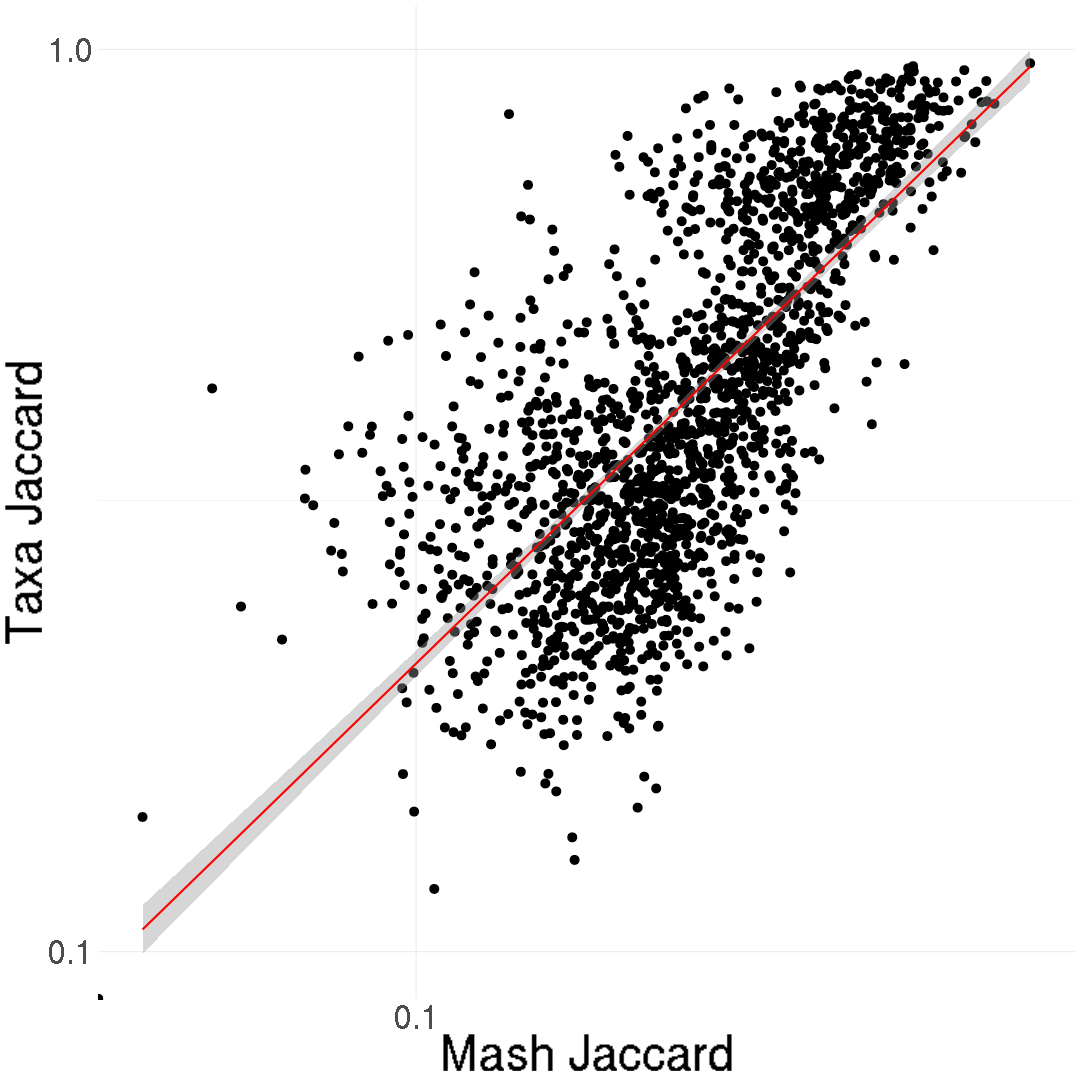

In [51]:
%%R -i merged -w 1080 -h 1080

ggplot(merged, aes(x=mash_jaccard, y=taxa_jaccard)) +
    geom_point(size=4) +
    theme_minimal() +
    ylab('Taxa Jaccard') +
    xlab('Mash Jaccard') +
    scale_x_log10() +
    scale_y_log10() +
    geom_smooth(method='lm', color='red') +
    theme(
        text = element_text(size=50),
        legend.position='right',
    )

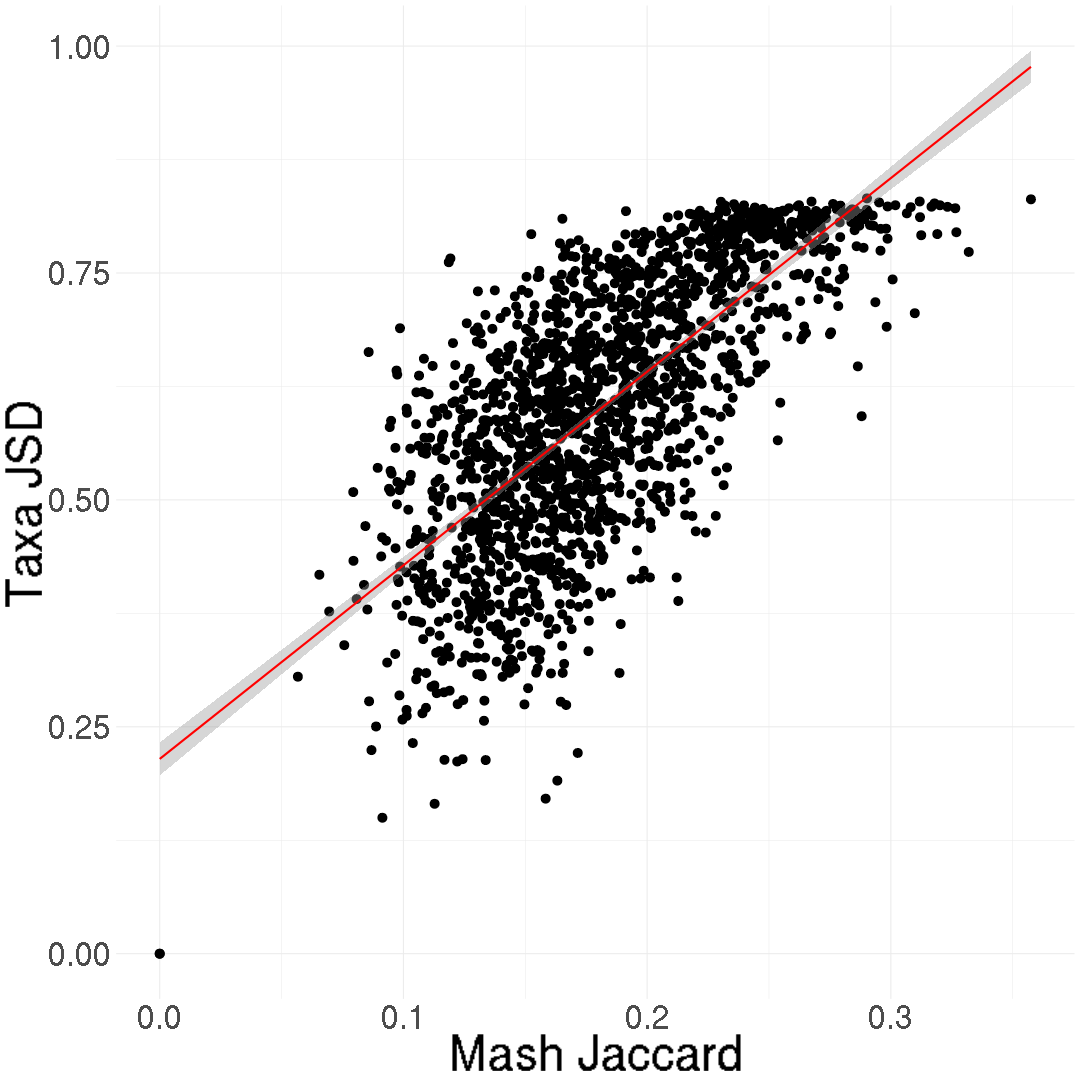

In [52]:
%%R -i merged -w 1080 -h 1080

ggplot(merged, aes(x=mash_jaccard, y=taxa_jsd)) +
    geom_point(size=4) +
    theme_minimal() +
    ylab('Taxa JSD') +
    xlab('Mash Jaccard') +
    geom_smooth(method='lm', color='red') +
    theme(
        text = element_text(size=50),
        legend.position='right',
    )

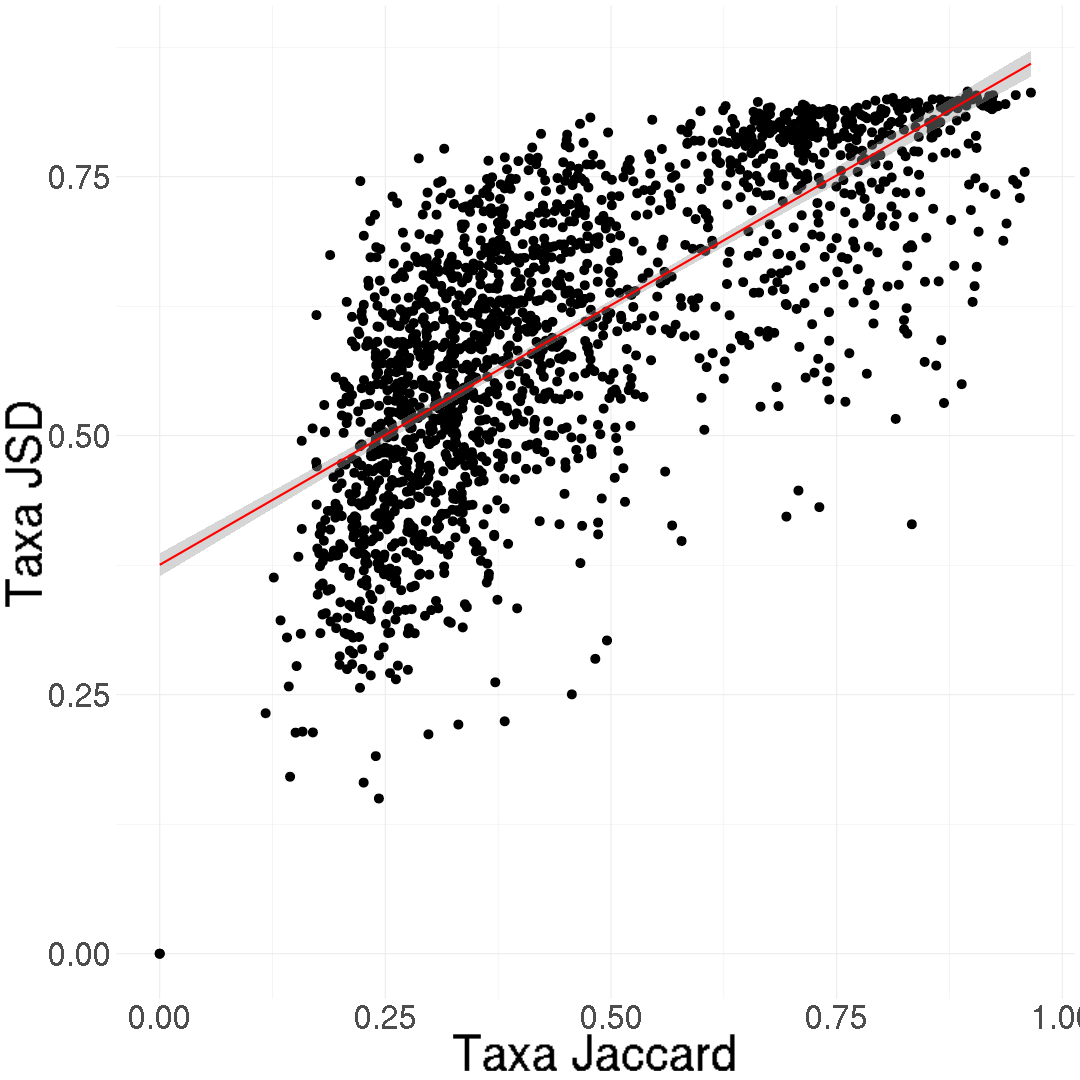

In [50]:
%%R -i merged -w 1080 -h 1080

ggplot(merged, aes(x=taxa_jaccard, y=taxa_jsd)) +
    geom_point(size=4) +
    theme_minimal() +
    ylab('Taxa JSD') +
    xlab('Taxa Jaccard') +
    geom_smooth(method='lm', color='red') +
    theme(
        text = element_text(size=50),
        legend.position='right',
    )

In [53]:
merged.corr()



,mash_jaccard,mash_pval,taxa_jsd,taxa_jaccard
mash_jaccard,1.000000,NaN,0.708065,0.767465
mash_pval,NaN,NaN,NaN,NaN
taxa_jsd,0.708065,NaN,1.000000,0.712702
taxa_jaccard,0.767465,NaN,0.712702,1.000000


In [54]:
merged.corr(method='spearman')

,mash_jaccard,mash_pval,taxa_jsd,taxa_jaccard
mash_jaccard,1.000000,NaN,0.714644,0.735869
mash_pval,NaN,NaN,NaN,NaN
taxa_jsd,0.714644,NaN,1.000000,0.739645
taxa_jaccard,0.735869,NaN,0.739645,1.000000


## Alpha Diversity Correlation

In [59]:
kmer_stats = core_tabler.csv_in_dir('other/kmer_complexity_stats.csv')

taxa = core_tabler.taxonomy()
taxa_richness = core_tabler.alpha_diversity(taxa, metric='richness')
taxa_entropy = core_tabler.alpha_diversity(taxa, metric='shannon_entropy')

alphas = pd.concat([kmer_stats['entropy'], kmer_stats['n_kmers'], taxa_richness, taxa_entropy], axis=1)
alphas.columns = ['entropy', 'n_kmers', 'taxa_richness', 'taxa_entropy']

alphas.head()

,entropy,n_kmers,taxa_richness,taxa_entropy
haib17CEM4890_H2NYMCCXY_SL254769,19.950375,1099185.0,1193.0,6.271000
haib17CEM4890_H2NYMCCXY_SL254770,19.908081,1082537.0,1568.0,4.927334
haib17CEM4890_H2NYMCCXY_SL254771,19.970478,1117917.0,1313.0,4.212011
haib17CEM4890_H2NYMCCXY_SL254772,20.008963,1121871.0,1440.0,3.496155
haib17CEM4890_H2NYMCCXY_SL254773,19.807475,1045651.0,1729.0,8.148318


In [62]:
alphas.corr(method='pearson')

,entropy,n_kmers,taxa_richness,taxa_entropy
entropy,1.000000,0.904870,0.323501,0.274330
n_kmers,0.904870,1.000000,0.346319,0.323787
taxa_richness,0.323501,0.346319,1.000000,0.541792
taxa_entropy,0.274330,0.323787,0.541792,1.000000


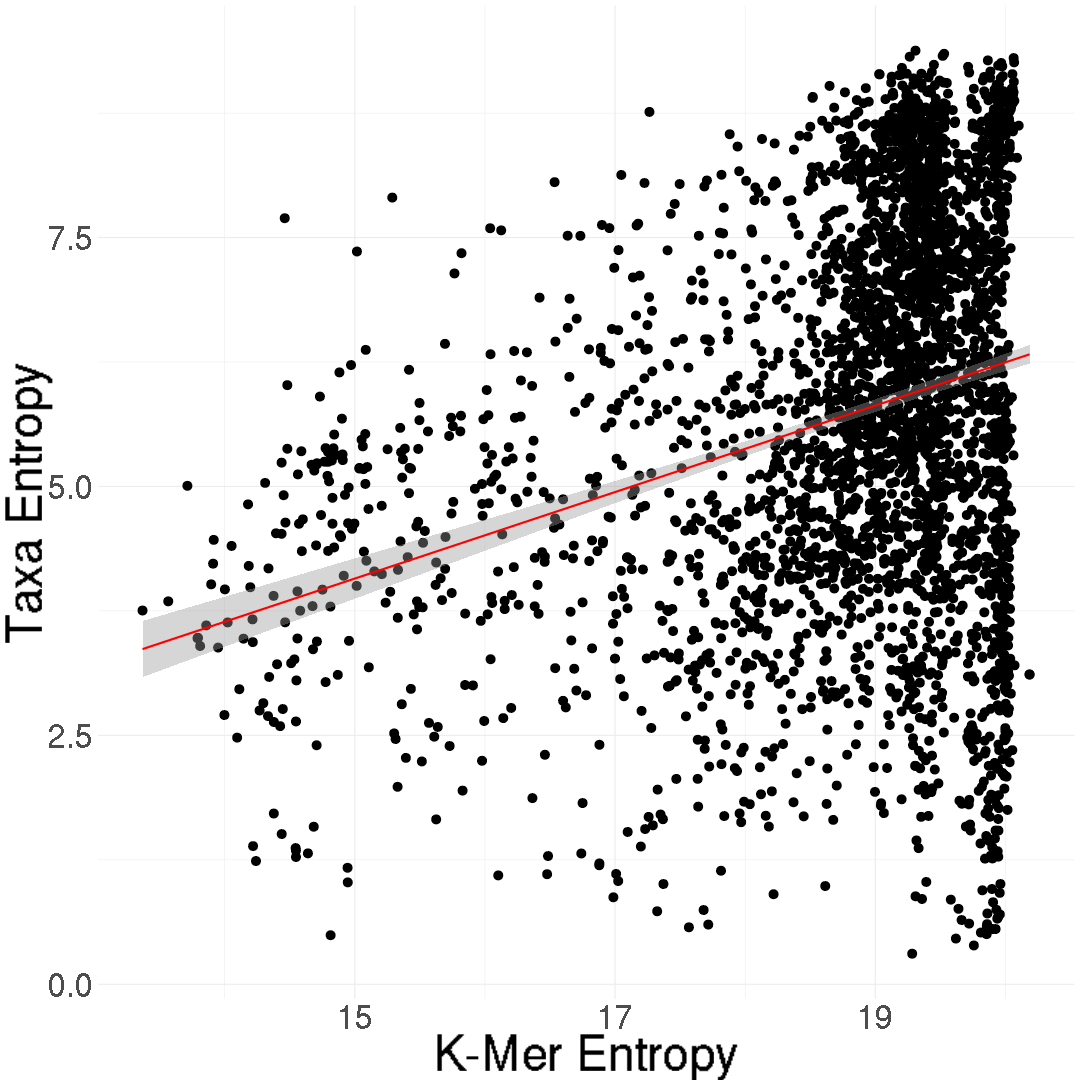

In [66]:
%%R -i alphas -w 1080 -h 1080

ggplot(alphas, aes(x=entropy, y=taxa_entropy)) +
    geom_point(size=4) +
    theme_minimal() +
    ylab('Taxa Entropy') +
    xlab('K-Mer Entropy') +
    geom_smooth(method='lm', color='red') +
    theme(
        text = element_text(size=50),
        legend.position='right',
    )



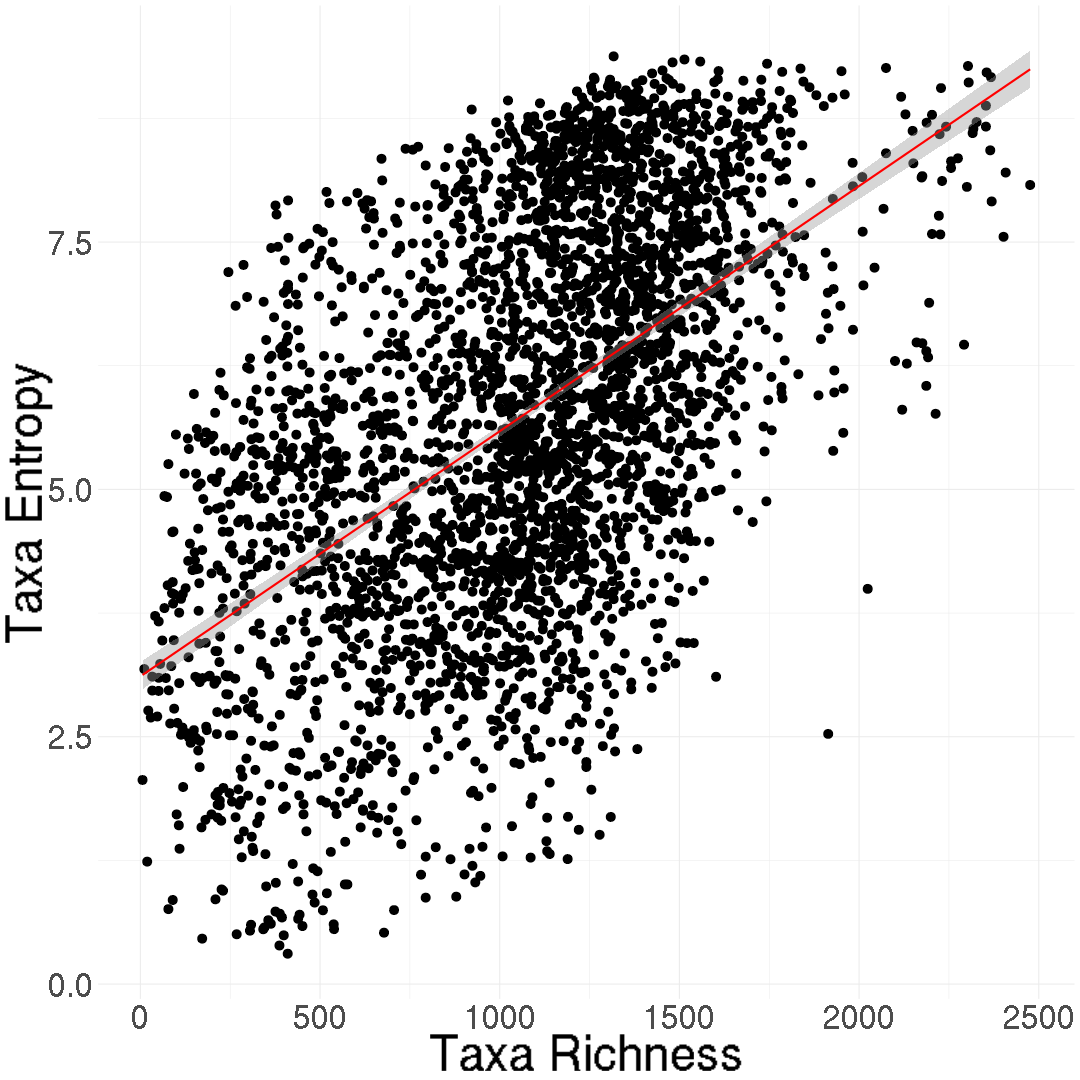

In [67]:
%%R -i alphas -w 1080 -h 1080

ggplot(alphas, aes(x=taxa_richness, y=taxa_entropy)) +
    geom_point(size=4) +
    theme_minimal() +
    ylab('Taxa Entropy') +
    xlab('Taxa Richness') +
    geom_smooth(method='lm', color='red') +
    theme(
        text = element_text(size=50),
        legend.position='right',
    )

In [70]:
core_tabler.metadata['city'].value_counts()

hong_kong        725
london           576
ilorin           282
singapore        192
new_york_city    178
tokyo            160
barcelona        124
porto            112
fairbanks        100
kyiv              98
taipei            97
seoul             91
lisbon            84
doha              82
zurich            79
stockholm         64
berlin            55
denver            48
sacramento        34
kuala_lumpur      32
sendai            32
san_francisco     30
sao_paulo         29
oslo              28
other_control     28
santiago          27
offa              26
bogota            21
montevideo        20
minneapolis       19
auckland          16
paris             16
naples            16
sofia             16
antarctica        16
hamilton          16
vienna            16
hanoi             16
brisbane          16
marseille         16
baltimore         14
yamaguchi         12
mexico_city       10
shanghai          10
tsuruoka           5
fukuoka            3
sao paulo          3
san francisco

In [73]:
core_tabler.metadata['project'].value_counts()

CSD17    2716
CSD16     757
PILOT     219
Name: project, dtype: int64

In [75]:
core_tabler.metadata.shape

(3692, 43)